In [38]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from sklearn.metrics import confusion_matrix


In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [138]:
all_latent_results = [] 
all_latent_confs = [] 
all_cl_results = [] 
all_cl_confs = [] 
all_enc_results = [] 
all_enc_confs = [] 

In [132]:
SEEDS = [42,28,24,12,76,37,95,58,86,61]

In [137]:
batch_size = 64
epochs = 100
import random
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=1, min_lr=1e-7, min_delta=0.01, cooldown=2)
# SEEDS = list(set([random.randint(0,100) for _ in range(10)]))
latent_results = []
cl_results = []
enc_results = []
latent_confs = []
cl_confs = []
enc_confs = []
for seed in tqdm(SEEDS):
    np.random.seed(0)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

    input_img = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2, 2), padding='same')(x)
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
#     x = layers.UpSampling2D((2, 2))(x)
#     x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, [decoded,encoded])

    cl_out = layers.Flatten()(encoded)
    cl_out = layers.Dense(num_classes, activation="softmax")(cl_out)
    cl_model = keras.Model(input_img, cl_out)
    enc_model = keras.Model(input_img,cl_out)
    
    
    latent_inp = layers.Input(shape=autoencoder.output[1].shape[1:])
    latent_x = layers.Flatten()(latent_inp)
    latent_out = layers.Dense(num_classes, activation="softmax")(latent_x)
    latent_model = keras.Model(latent_inp, latent_out)

    autoencoder.compile(optimizer='adam', loss=['binary_crossentropy',None])
    cl_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    latent_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    enc_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


    autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[es,reduce_lr], verbose=0)
    latent_x_test = autoencoder.predict(x_test)[1]
    latent_x_train = autoencoder.predict(x_train)[1]
    
    cl_model.fit(x_train, y_train, batch_size=batch_size, epochs=60, validation_split=0.1, callbacks=[es,reduce_lr], verbose=0)
    cl_result = cl_model.evaluate(x_test,y_test)
    cl_preds = cl_model.predict(x_test)
    cl_conf = confusion_matrix(y_test.argmax(axis=1), cl_preds.argmax(axis=1))

    latent_model.fit(latent_x_train, y_train, batch_size=batch_size, epochs=60, validation_split=0.1, callbacks=[es,reduce_lr], verbose=0)
    latent_result = latent_model.evaluate(latent_x_test,y_test)
    latent_preds = latent_model.predict(latent_x_test)
    latent_conf = confusion_matrix(y_test.argmax(axis=1), latent_preds.argmax(axis=1))
    
    
    break_flag = False
    for i,layer in enumerate(autoencoder.layers):
        if(break_flag):
            break
        if(layer.name=='bottleneck'):
            break_flag = True
        enc_model.layers[i].set_weights(layer.get_weights())
        
    enc_model.fit(x_train, y_train, batch_size=batch_size, epochs=60, validation_split=0.1, callbacks=[es,reduce_lr], verbose=0)
    enc_result = enc_model.evaluate(x_test,y_test)
    enc_preds = enc_model.predict(x_test)
    enc_conf = confusion_matrix(y_test.argmax(axis=1), enc_preds.argmax(axis=1))
    
    
    latent_results.append(latent_result)
    latent_confs.append(latent_conf)
    cl_results.append(cl_result)
    cl_confs.append(cl_conf)
    enc_results.append(enc_result)
    enc_confs.append(enc_conf)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

313/313 [==============================] - 2s 6ms/step - loss: 0.2679 - accuracy: 0.9064


 10%|███████▉                                                                       | 1/10 [26:24<3:57:39, 1584.44s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2783 - accuracy: 0.9000


 20%|███████████████▊                                                               | 2/10 [51:46<3:28:46, 1565.77s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2612 - accuracy: 0.9094


 30%|███████████████████████                                                      | 3/10 [1:17:09<3:01:10, 1552.91s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2620 - accuracy: 0.9095


 40%|██████████████████████████████▊                                              | 4/10 [1:45:25<2:39:34, 1595.74s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2593 - accuracy: 0.9117


 50%|██████████████████████████████████████▌                                      | 5/10 [2:13:20<2:14:58, 1619.67s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2596 - accuracy: 0.9109


 60%|██████████████████████████████████████████████▏                              | 6/10 [2:38:52<1:46:13, 1593.42s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2626 - accuracy: 0.9086


 70%|█████████████████████████████████████████████████████▉                       | 7/10 [3:04:45<1:19:03, 1581.26s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2545 - accuracy: 0.9130


 80%|███████████████████████████████████████████████████████████████▏               | 8/10 [3:32:55<53:47, 1613.67s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2572 - accuracy: 0.9137


 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [3:59:02<26:39, 1599.83s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2520 - accuracy: 0.9105


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [4:25:15<00:00, 1591.56s/it]


In [129]:
latent_results

[[0.3366886377334595, 0.8799999952316284],
 [0.33746105432510376, 0.8794999718666077],
 [0.3391571342945099, 0.8787999749183655],
 [0.32993531227111816, 0.8780999779701233],
 [0.32735583186149597, 0.8851000070571899],
 [0.3334304094314575, 0.8799999952316284],
 [0.333842933177948, 0.8808000087738037],
 [0.34342435002326965, 0.8730000257492065],
 [0.3559562861919403, 0.871399998664856],
 [0.34656035900115967, 0.8766999840736389]]

In [130]:
cl_results

[[0.2668095827102661, 0.90420001745224],
 [0.26464203000068665, 0.9059000015258789],
 [0.2572406530380249, 0.9072999954223633],
 [0.26983317732810974, 0.9032999873161316],
 [0.25844523310661316, 0.9093000292778015],
 [0.2790881395339966, 0.9021999835968018],
 [0.2665964365005493, 0.9039000272750854],
 [0.2896513044834137, 0.8942999839782715],
 [0.2760055661201477, 0.9020000100135803],
 [0.2670537233352661, 0.9129999876022339]]

In [139]:
all_latent_results.append(latent_results)
all_latent_confs.append(latent_confs)
all_cl_results.append(cl_results)
all_cl_confs.append(cl_confs)
all_enc_results.append(enc_results)
all_enc_confs.append(enc_confs)


In [141]:
batch_size = 128
epochs = 50
import random
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=2)

# SEEDS = list(set([random.randint(0,100) for _ in range(10)]))
latent_results = []
cl_results = []
enc_results = []
latent_confs = []
cl_confs = []
enc_confs = []

for seed in tqdm(SEEDS):
    np.random.seed(0)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

    input_img = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2, 2), padding='same')(x)
#     x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)


    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
#     x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, [decoded,encoded])

    cl_out = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    cl_out = layers.Flatten()(cl_out)
    cl_out = layers.Dense(num_classes, activation="softmax")(cl_out)
    cl_model = keras.Model(input_img, cl_out)

    latent_inp = layers.Input(shape=autoencoder.output[1].shape[1:])
    latent_x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(latent_inp)
    latent_x = layers.Flatten()(latent_x)
    latent_out = layers.Dense(num_classes, activation="softmax")(latent_x)
    latent_model = keras.Model(latent_inp, latent_out)
    
    enc_model = keras.Model(input_img,cl_out)
    enc_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    

    autoencoder.compile(optimizer='adam', loss=['binary_crossentropy',None])
    cl_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    latent_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


    autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[es], verbose=0)
    latent_x_test = autoencoder.predict(x_test)[1]
    latent_x_train = autoencoder.predict(x_train)[1]
    
    cl_model.fit(x_train, y_train, batch_size=batch_size, epochs=60, validation_split=0.1, callbacks=[es], verbose=0)
    cl_result = cl_model.evaluate(x_test,y_test)
    cl_preds = cl_model.predict(x_test)
    cl_conf = confusion_matrix(y_test.argmax(axis=1), cl_preds.argmax(axis=1))

    latent_model.fit(latent_x_train, y_train, batch_size=batch_size, epochs=60, validation_split=0.1, callbacks=[es], verbose=0)
    latent_result = latent_model.evaluate(latent_x_test,y_test)
    latent_preds = latent_model.predict(latent_x_test)
    latent_conf = confusion_matrix(y_test.argmax(axis=1), latent_preds.argmax(axis=1))
    
    break_flag = False
    for i,layer in enumerate(autoencoder.layers):
        if(break_flag):
            break
        if(layer.name=='bottleneck'):
            break_flag = True
        enc_model.layers[i].set_weights(layer.get_weights())
        
    
    enc_model.fit(x_train, y_train, batch_size=batch_size, epochs=60, validation_split=0.1, callbacks=[es,reduce_lr], verbose=0)
    enc_result = enc_model.evaluate(x_test,y_test)
    enc_preds = enc_model.predict(x_test)
    enc_conf = confusion_matrix(y_test.argmax(axis=1), enc_preds.argmax(axis=1))
    
    
    latent_results.append(latent_result)
    latent_confs.append(latent_conf)
    cl_results.append(cl_result)
    cl_confs.append(cl_conf)
    enc_results.append(enc_result)
    enc_confs.append(enc_conf)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

313/313 [==============================] - 2s 6ms/step - loss: 0.2770 - accuracy: 0.9225


 10%|████████▏                                                                         | 1/10 [06:05<54:45, 365.07s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2501 - accuracy: 0.9171


 20%|████████████████▍                                                                 | 2/10 [10:34<44:51, 336.41s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2640 - accuracy: 0.9191


 30%|████████████████████████▌                                                         | 3/10 [14:36<35:56, 308.13s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2638 - accuracy: 0.9179


 40%|████████████████████████████████▊                                                 | 4/10 [19:45<30:50, 308.39s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2797 - accuracy: 0.9219


 50%|█████████████████████████████████████████                                         | 5/10 [24:41<25:22, 304.50s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2754 - accuracy: 0.9208


 60%|█████████████████████████████████████████████████▏                                | 6/10 [30:11<20:48, 312.15s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2724 - accuracy: 0.9175


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [33:49<14:11, 283.87s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2510 - accuracy: 0.9222


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [38:48<09:37, 288.61s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2626 - accuracy: 0.9217


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [42:10<04:22, 262.42s/it]

313/313 [==============================] - 2s 6ms/step - loss: 0.2687 - accuracy: 0.9215


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [45:57<00:00, 275.79s/it]


In [142]:
all_latent_results.append(latent_results)
all_latent_confs.append(latent_confs)
all_cl_results.append(cl_results)
all_cl_confs.append(cl_confs)
all_enc_results.append(enc_results)
all_enc_confs.append(enc_confs)


In [46]:
latent_results

[[0.28781184554100037, 0.8974000215530396],
 [0.30332034826278687, 0.8930000066757202],
 [0.3283125162124634, 0.8779000043869019],
 [0.27776020765304565, 0.902899980545044],
 [0.276668906211853, 0.9017000198364258],
 [0.2766176462173462, 0.9025999903678894],
 [0.2759452164173126, 0.9049000144004822],
 [0.27012383937835693, 0.9046000242233276],
 [0.26988062262535095, 0.9078999757766724],
 [0.2595105767250061, 0.910099983215332]]

In [47]:
cl_results

[[0.2595506012439728, 0.9136000275611877],
 [0.29333731532096863, 0.910099983215332],
 [0.23983389139175415, 0.9164000153541565],
 [0.2670044004917145, 0.909600019454956],
 [0.24210616946220398, 0.9180999994277954],
 [0.2500377893447876, 0.9146000146865845],
 [0.26518282294273376, 0.9128999710083008],
 [0.25269821286201477, 0.9135000109672546],
 [0.24895432591438293, 0.9140999913215637],
 [0.25354185700416565, 0.9157999753952026]]

In [168]:
enc_results

[[0.2678588926792145, 0.9064000248908997],
 [0.2782605290412903, 0.8999999761581421],
 [0.2611929476261139, 0.9093999862670898],
 [0.26198092103004456, 0.909500002861023],
 [0.2593088746070862, 0.9117000102996826],
 [0.2596052587032318, 0.9108999967575073],
 [0.26256898045539856, 0.9085999727249146],
 [0.2544918358325958, 0.9129999876022339],
 [0.2572127878665924, 0.9136999845504761],
 [0.25201842188835144, 0.9104999899864197],
 [0.27700749039649963, 0.9225000143051147],
 [0.25012969970703125, 0.9171000123023987],
 [0.26402547955513, 0.9190999865531921],
 [0.2638247013092041, 0.917900025844574],
 [0.2796509265899658, 0.9218999743461609],
 [0.27540096640586853, 0.920799970626831],
 [0.2723618745803833, 0.9175000190734863],
 [0.2510272264480591, 0.9222000241279602],
 [0.26256808638572693, 0.9217000007629395],
 [0.2686785161495209, 0.921500027179718],
 [0.2537418603897095, 0.9189000129699707],
 [0.29510143399238586, 0.9117000102996826],
 [0.2451588660478592, 0.920199990272522],
 [0.246989

In [156]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow import Tensor

def relu_bn(inputs: Tensor,encoder:bool = False) -> Tensor:
    relu = ReLU()(inputs)
    bn = None
    if(encoder):
        bn = BatchNormalization(name='bottleneck')(relu)
    else:
        bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool,upsample:bool, filters: int, kernel_size: int = 3, encoder:bool = False) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)
    if upsample:
        y = Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(y)
        x = Conv2DTranspose(filters, (3,3), strides=(2,2), padding='same')(x)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    if(encoder):
        out = relu_bn(out,True)
    else:
        out = relu_bn(out)
    return out

In [159]:
batch_size = 128
epochs = 50
import random
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
# from blocks_3 import residual_block
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=2)

SEEDS = list(set([random.randint(0,100) for _ in range(10)]))
latent_results = []
cl_results = []
enc_results = []
latent_confs = []
cl_confs = []
enc_confs = []
for seed in tqdm(SEEDS):
    np.random.seed(0)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

    input_img = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    num_blocks_list = [1, 1, 1]
    num_filters = 32
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            if(i==len(num_blocks_list)-1 and j==num_blocks-1):
                x = residual_block(x, downsample=(j==0 and i!=0),upsample=False, filters=num_filters, encoder=True)
            else:
                x = residual_block(x, downsample=(j==0 and i!=0),upsample=False, filters=num_filters)
        num_filters = int(num_filters/2)
    encoded = x
    num_filters = int(num_filters*2)
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            x = residual_block(x, downsample=False, upsample=(j==0 and i!=0), filters=num_filters)
        num_filters = int(num_filters*2)

    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, [decoded,encoded])

    cl_out = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    cl_out = layers.Flatten()(cl_out)
    cl_out = layers.Dense(num_classes, activation="softmax")(cl_out)
    cl_model = keras.Model(input_img, cl_out)
    
    enc_model = keras.Model(input_img,cl_out)
    enc_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    

    latent_inp = layers.Input(shape=autoencoder.output[1].shape[1:])
    latent_x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(latent_inp)
    latent_x = layers.Flatten()(latent_x)
    latent_out = layers.Dense(num_classes, activation="softmax")(latent_x)
    latent_model = keras.Model(latent_inp, latent_out)

    autoencoder.compile(optimizer='adam', loss=['binary_crossentropy',None])
    cl_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    latent_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
#     print(autoencoder.summary())


    autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[es], verbose=0)
    latent_x_test = autoencoder.predict(x_test)[1]
    latent_x_train = autoencoder.predict(x_train)[1]
    
    cl_model.fit(x_train, y_train, batch_size=batch_size, epochs=60, validation_split=0.1, callbacks=[es], verbose=0)
    cl_result = cl_model.evaluate(x_test,y_test)
    cl_preds = cl_model.predict(x_test)
    cl_conf = confusion_matrix(y_test.argmax(axis=1), cl_preds.argmax(axis=1))

    latent_model.fit(latent_x_train, y_train, batch_size=batch_size, epochs=60, validation_split=0.1, callbacks=[es], verbose=0)
    latent_result = latent_model.evaluate(latent_x_test,y_test)
    latent_preds = latent_model.predict(latent_x_test)
    latent_conf = confusion_matrix(y_test.argmax(axis=1), latent_preds.argmax(axis=1))
    
    break_flag = False
    for i,layer in enumerate(autoencoder.layers):
        print(layer.name)
        if(break_flag):
            break
        if(layer.name=='bottleneck'):
            break_flag = True
        enc_model.layers[i].set_weights(layer.get_weights())
        
    
    enc_model.fit(x_train, y_train, batch_size=batch_size, epochs=60, validation_split=0.1, callbacks=[es,reduce_lr], verbose=0)
    enc_result = enc_model.evaluate(x_test,y_test)
    enc_preds = enc_model.predict(x_test)
    enc_conf = confusion_matrix(y_test.argmax(axis=1), enc_preds.argmax(axis=1))
    
    
    latent_results.append(latent_result)
    latent_confs.append(latent_conf)
    cl_results.append(cl_result)
    cl_confs.append(cl_conf)
    enc_results.append(enc_result)
    enc_confs.append(enc_conf)
    

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\Daniel\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


313/313 [==============================] - 2s 5ms/step - loss: 0.3117 - accuracy: 0.8856
input_310
conv2d_1850
conv2d_1851
re_lu_830
batch_normalization_819
conv2d_1852
add_420
re_lu_831
batch_normalization_820
conv2d_1853
re_lu_832
batch_normalization_821
conv2d_1855
conv2d_1854
add_421
re_lu_833
batch_normalization_822
conv2d_1856
re_lu_834
batch_normalization_823
conv2d_1858
conv2d_1857
add_422
re_lu_835
bottleneck
conv2d_1859
313/313 [==============================] - 3s 10ms/step - loss: 0.2537 - accuracy: 0.9189


 10%|████████▏                                                                         | 1/10 [05:30<49:32, 330.28s/it]

313/313 [==============================] - 2s 5ms/step - loss: 0.3142 - accuracy: 0.8892
input_312
conv2d_1868
conv2d_1869
re_lu_842
batch_normalization_830
conv2d_1870
add_426
re_lu_843
batch_normalization_831
conv2d_1871
re_lu_844
batch_normalization_832
conv2d_1873
conv2d_1872
add_427
re_lu_845
batch_normalization_833
conv2d_1874
re_lu_846
batch_normalization_834
conv2d_1876
conv2d_1875
add_428
re_lu_847
bottleneck
conv2d_1877
313/313 [==============================] - 3s 10ms/step - loss: 0.2951 - accuracy: 0.9117


 20%|████████████████▍                                                                 | 2/10 [10:21<42:29, 318.69s/it]

313/313 [==============================] - 2s 5ms/step - loss: 0.3334 - accuracy: 0.8817
input_314
conv2d_1886
conv2d_1887
re_lu_854
batch_normalization_841
conv2d_1888
add_432
re_lu_855
batch_normalization_842
conv2d_1889
re_lu_856
batch_normalization_843
conv2d_1891
conv2d_1890
add_433
re_lu_857
batch_normalization_844
conv2d_1892
re_lu_858
batch_normalization_845
conv2d_1894
conv2d_1893
add_434
re_lu_859
bottleneck
conv2d_1895
313/313 [==============================] - 3s 10ms/step - loss: 0.2452 - accuracy: 0.9202


 30%|████████████████████████▌                                                         | 3/10 [16:34<39:03, 334.85s/it]

313/313 [==============================] - 2s 5ms/step - loss: 0.3060 - accuracy: 0.8910
input_316
conv2d_1904
conv2d_1905
re_lu_866
batch_normalization_852
conv2d_1906
add_438
re_lu_867
batch_normalization_853
conv2d_1907
re_lu_868
batch_normalization_854
conv2d_1909
conv2d_1908
add_439
re_lu_869
batch_normalization_855
conv2d_1910
re_lu_870
batch_normalization_856
conv2d_1912
conv2d_1911
add_440
re_lu_871
bottleneck
conv2d_1913
313/313 [==============================] - 3s 10ms/step - loss: 0.2470 - accuracy: 0.9187


 40%|████████████████████████████████▊                                                 | 4/10 [22:38<34:21, 343.62s/it]

313/313 [==============================] - 2s 5ms/step - loss: 0.3069 - accuracy: 0.8911
input_318
conv2d_1922
conv2d_1923
re_lu_878
batch_normalization_863
conv2d_1924
add_444
re_lu_879
batch_normalization_864
conv2d_1925
re_lu_880
batch_normalization_865
conv2d_1927
conv2d_1926
add_445
re_lu_881
batch_normalization_866
conv2d_1928
re_lu_882
batch_normalization_867
conv2d_1930
conv2d_1929
add_446
re_lu_883
bottleneck
conv2d_1931
313/313 [==============================] - 3s 10ms/step - loss: 0.2476 - accuracy: 0.9166


 50%|█████████████████████████████████████████                                         | 5/10 [29:28<30:16, 363.37s/it]

313/313 [==============================] - 2s 5ms/step - loss: 0.3040 - accuracy: 0.8929
input_320
conv2d_1940
conv2d_1941
re_lu_890
batch_normalization_874
conv2d_1942
add_450
re_lu_891
batch_normalization_875
conv2d_1943
re_lu_892
batch_normalization_876
conv2d_1945
conv2d_1944
add_451
re_lu_893
batch_normalization_877
conv2d_1946
re_lu_894
batch_normalization_878
conv2d_1948
conv2d_1947
add_452
re_lu_895
bottleneck
conv2d_1949
313/313 [==============================] - 3s 10ms/step - loss: 0.2431 - accuracy: 0.9250


 60%|█████████████████████████████████████████████████▏                                | 6/10 [35:33<24:16, 364.14s/it]

313/313 [==============================] - 2s 5ms/step - loss: 0.3121 - accuracy: 0.8860
input_322
conv2d_1958
conv2d_1959
re_lu_902
batch_normalization_885
conv2d_1960
add_456
re_lu_903
batch_normalization_886
conv2d_1961
re_lu_904
batch_normalization_887
conv2d_1963
conv2d_1962
add_457
re_lu_905
batch_normalization_888
conv2d_1964
re_lu_906
batch_normalization_889
conv2d_1966
conv2d_1965
add_458
re_lu_907
bottleneck
conv2d_1967
313/313 [==============================] - 3s 10ms/step - loss: 0.2488 - accuracy: 0.9184


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [42:36<19:05, 381.69s/it]

313/313 [==============================] - 2s 5ms/step - loss: 0.3110 - accuracy: 0.8844
input_324
conv2d_1976
conv2d_1977
re_lu_914
batch_normalization_896
conv2d_1978
add_462
re_lu_915
batch_normalization_897
conv2d_1979
re_lu_916
batch_normalization_898
conv2d_1981
conv2d_1980
add_463
re_lu_917
batch_normalization_899
conv2d_1982
re_lu_918
batch_normalization_900
conv2d_1984
conv2d_1983
add_464
re_lu_919
bottleneck
conv2d_1985
313/313 [==============================] - 3s 10ms/step - loss: 0.2859 - accuracy: 0.9166


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [54:27<16:00, 480.45s/it]

313/313 [==============================] - 2s 5ms/step - loss: 0.3130 - accuracy: 0.8873
input_326
conv2d_1994
conv2d_1995
re_lu_926
batch_normalization_907
conv2d_1996
add_468
re_lu_927
batch_normalization_908
conv2d_1997
re_lu_928
batch_normalization_909
conv2d_1999
conv2d_1998
add_469
re_lu_929
batch_normalization_910
conv2d_2000
re_lu_930
batch_normalization_911
conv2d_2002
conv2d_2001
add_470
re_lu_931
bottleneck
conv2d_2003
313/313 [==============================] - 3s 10ms/step - loss: 0.2417 - accuracy: 0.9249


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:00:52<07:31, 451.68s/it]

313/313 [==============================] - 2s 5ms/step - loss: 0.3109 - accuracy: 0.8909
input_328
conv2d_2012
conv2d_2013
re_lu_938
batch_normalization_918
conv2d_2014
add_474
re_lu_939
batch_normalization_919
conv2d_2015
re_lu_940
batch_normalization_920
conv2d_2017
conv2d_2016
add_475
re_lu_941
batch_normalization_921
conv2d_2018
re_lu_942
batch_normalization_922
conv2d_2020
conv2d_2019
add_476
re_lu_943
bottleneck
conv2d_2021
313/313 [==============================] - 3s 10ms/step - loss: 0.2610 - accuracy: 0.9199


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:08:25<00:00, 410.58s/it]


In [167]:
all_cl_results

[[[0.2739515006542206, 0.9035000205039978],
  [0.27225327491760254, 0.9035999774932861],
  [0.2766450047492981, 0.9006999731063843],
  [0.27050071954727173, 0.9034000039100647],
  [0.2632339894771576, 0.9068999886512756],
  [0.2673584818840027, 0.9041000008583069],
  [0.26736289262771606, 0.9049000144004822],
  [0.2604537010192871, 0.909600019454956],
  [0.2670741081237793, 0.9067999720573425],
  [0.25989463925361633, 0.9060999751091003]],
 [[0.2533012926578522, 0.916700005531311],
  [0.2473243623971939, 0.9121999740600586],
  [0.2595638632774353, 0.9110000133514404],
  [0.25996965169906616, 0.9124000072479248],
  [0.2504638433456421, 0.9154999852180481],
  [0.2535710334777832, 0.9118000268936157],
  [0.246689572930336, 0.9156000018119812],
  [0.2662191092967987, 0.9078999757766724],
  [0.24600781500339508, 0.920199990272522],
  [0.2597798705101013, 0.9126999974250793]],
 [[0.25589874386787415, 0.9111999869346619],
  [0.28519779443740845, 0.9053000211715698],
  [0.27989596128463745, 0.

In [172]:
all_enc_results

[[[0.2678588926792145, 0.9064000248908997],
  [0.2782605290412903, 0.8999999761581421],
  [0.2611929476261139, 0.9093999862670898],
  [0.26198092103004456, 0.909500002861023],
  [0.2593088746070862, 0.9117000102996826],
  [0.2596052587032318, 0.9108999967575073],
  [0.26256898045539856, 0.9085999727249146],
  [0.2544918358325958, 0.9129999876022339],
  [0.2572127878665924, 0.9136999845504761],
  [0.25201842188835144, 0.9104999899864197],
  [0.27700749039649963, 0.9225000143051147],
  [0.25012969970703125, 0.9171000123023987],
  [0.26402547955513, 0.9190999865531921],
  [0.2638247013092041, 0.917900025844574],
  [0.2796509265899658, 0.9218999743461609],
  [0.27540096640586853, 0.920799970626831],
  [0.2723618745803833, 0.9175000190734863],
  [0.2510272264480591, 0.9222000241279602],
  [0.26256808638572693, 0.9217000007629395],
  [0.2686785161495209, 0.921500027179718],
  [0.2537418603897095, 0.9189000129699707],
  [0.29510143399238586, 0.9117000102996826],
  [0.2451588660478592, 0.92019

In [184]:
all_enc_results_corrected = [r[0+i*10:((i+1)*10)] for i,r in enumerate(all_enc_results)]

In [160]:
all_latent_results.append(latent_results)
all_latent_confs.append(latent_confs)
all_cl_results.append(cl_results)
all_cl_confs.append(cl_confs)
all_enc_results.append(enc_results)
all_enc_confs.append(enc_confs)


In [161]:
fr_backup = full_results.copy()

In [162]:
full_results = dict()
full_results['labent-res'] = all_latent_results
full_results['latent-conf'] = all_latent_confs
full_results['cl-res'] = all_cl_results
full_results['cl-conf'] = all_cl_confs
full_results['enc-res'] = all_enc_results
full_results['enc-conf'] = all_enc_confs

In [163]:
import pickle

In [164]:
import pickle
with open('full-res-all2.pkl', 'wb') as f:
    pickle.dump(full_results, f)

In [96]:
fr = None
with open('full-res.pkl', 'rb') as f:
    fr = pickle.load(f)

In [185]:
alr = all_latent_results.copy()
acr = all_cl_results.copy()
aer = all_enc_results_corrected.copy()
import functools
import operator
alr = functools.reduce(operator.iconcat, alr, [])
acr = functools.reduce(operator.iconcat, acr, [])
aer = functools.reduce(operator.iconcat, aer, [])
alr_acc = [acc for l,acc in alr]
acr_acc = [acc for l,acc in acr]
aer_acc = [acc for l,acc in aer]

In [187]:
import pandas as pd
results_accs= pd.DataFrame(data = zip(acr_acc,alr_acc,aer_acc), columns = ['Control', 'Experimental1','Experimental2'])

<AxesSubplot:>

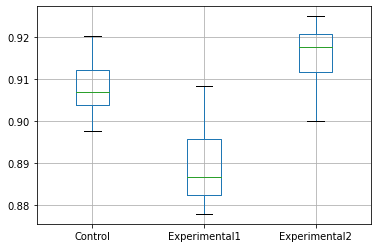

In [188]:
results_accs.boxplot(showfliers=False)

In [219]:
from scipy import stats
alpha = 0.05;

s, p = stats.normaltest(acr_acc)
print(s,p)
if p < alpha:
    print('Control data is not normal')
else:
    print('Control data is normal')

s, p = stats.normaltest(alr_acc)
print(s,p)
if p < alpha:
    print('Experimental1 data is not normal')
else:
    print('Experimental1 data is normal')
    
    
s, p = stats.normaltest(alr_acc)
print(s,p)
if p < alpha:
    print('Experimental2 data is not normal')
else:
    print('Experimental2 data is normal')

0.7917389657211209 0.6730945405786548
Control data is normal
3.1722900130000165 0.20471326085762026
Experimental1 data is normal
3.1722900130000165 0.20471326085762026
Experimental2 data is normal


In [190]:
stats.ttest_ind(acr_acc, alr_acc, axis=0, equal_var=True, nan_policy='propagate')

Ttest_indResult(statistic=10.702711329379646, pvalue=2.359085404154885e-15)

In [191]:
stats.ttest_ind(acr_acc, aer_acc, axis=0, equal_var=True, nan_policy='propagate')

Ttest_indResult(statistic=-5.521434286249591, pvalue=8.258608129799461e-07)

In [217]:
pearson_coef, p_value = stats.pearsonr(acr_acc, aer_acc) #define the columns to perform calculations on

pearson_coef, p_value

(0.5261765843581757, 0.0028204881982267466)

In [218]:
pearson_coef, p_value = stats.pearsonr(acr_acc, alr_acc) #define the columns to perform calculations on

pearson_coef, p_value

(0.7008460551015137, 1.6097221826014343e-05)

In [214]:
pearson_coef

-0.7426106572325056

In [108]:
p_value

0.001527218841404332

In [97]:
from scipy import stats

alpha = 0.05;

s, p = stats.normaltest(results_control_auc)
print(p)
if p < alpha:
    print('Control data is not normal')
else:
    print('Control data is normal')

s, p = stats.normaltest(results_experimental_auc)
print(p)
if p < alpha:
    print('Experimental data is not normal')
else:
    print('Experimental data is normal')

{'labent-res': [[[0.33800819516181946, 0.8794000148773193],
   [0.32165902853012085, 0.8853999972343445],
   [0.3323689103126526, 0.8809999823570251],
   [0.33443623781204224, 0.8823000192642212],
   [0.3438498377799988, 0.8730999827384949],
   [0.32030001282691956, 0.882099986076355],
   [0.32871881127357483, 0.8831999897956848],
   [0.33040332794189453, 0.8831999897956848],
   [0.3297611474990845, 0.882099986076355],
   [0.35399872064590454, 0.8759999871253967]],
  [[0.28781184554100037, 0.8974000215530396],
   [0.30332034826278687, 0.8930000066757202],
   [0.3283125162124634, 0.8779000043869019],
   [0.27776020765304565, 0.902899980545044],
   [0.276668906211853, 0.9017000198364258],
   [0.2766176462173462, 0.9025999903678894],
   [0.2759452164173126, 0.9049000144004822],
   [0.27012383937835693, 0.9046000242233276],
   [0.26988062262535095, 0.9078999757766724],
   [0.2595105767250061, 0.910099983215332]],
  [[0.2958972454071045, 0.8945000171661377],
   [0.32086509466171265, 0.88480

In [31]:
latent_inp = layers.Input(shape=autoencoder.output[1].shape[1:])
latent_x = layers.Flatten()(latent_inp)
latent_out = layers.Dense(num_classes, activation="softmax")(latent_x)
latent_model = keras.Model(latent_inp, latent_out)

In [32]:
latent_x_test = autoencoder.predict(x_test)[1]
latent_x_train = autoencoder.predict(x_train)[1]

In [33]:
latent_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

latent_model.fit(latent_x_train, y_train, batch_size=batch_size, epochs=60, validation_split=0.1, callbacks=[es])

latent_model.evaluate(latent_x_test,y_test)

Epoch 1/60
422/422 [==============================] - 3s 8ms/step - loss: 0.6237 - accuracy: 0.7915 - val_loss: 0.2792 - val_accuracy: 0.8993
Epoch 2/60
422/422 [==============================] - 4s 8ms/step - loss: 0.2344 - accuracy: 0.9174 - val_loss: 0.2450 - val_accuracy: 0.9105
Epoch 3/60
422/422 [==============================] - 4s 8ms/step - loss: 0.2024 - accuracy: 0.9298 - val_loss: 0.2410 - val_accuracy: 0.9152
Epoch 4/60
422/422 [==============================] - 3s 8ms/step - loss: 0.1877 - accuracy: 0.9337 - val_loss: 0.2311 - val_accuracy: 0.9135
Epoch 5/60
422/422 [==============================] - 3s 8ms/step - loss: 0.1789 - accuracy: 0.9377 - val_loss: 0.2292 - val_accuracy: 0.9185
Epoch 6/60
422/422 [==============================] - 4s 8ms/step - loss: 0.1695 - accuracy: 0.9407 - val_loss: 0.2422 - val_accuracy: 0.9122
Epoch 7/60
313/313 [==============================] - 2s 5ms/step - loss: 0.2529 - accuracy: 0.9106


[0.252933144569397, 0.9106000065803528]

In [137]:
# model.summary()
model2 =  tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[model.outputs,model.get_layer(name="relu1").output],
)

In [138]:
model2.compile(optimizer='adam', loss=['binary_crossentropy',None])

In [139]:
batch_size = 128
epochs = 10

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)


model2.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[es])

Epoch 1/10
352/352 [==============================] - 42s 118ms/step - loss: 0.5792 - relu_loss: 0.5792 - val_loss: 0.6254 - val_relu_loss: 0.6254
Epoch 2/10
352/352 [==============================] - 41s 117ms/step - loss: 0.5595 - relu_loss: 0.5595 - val_loss: 0.6704 - val_relu_loss: 0.6704
Epoch 3/10
352/352 [==============================] - 41s 117ms/step - loss: 0.5802 - relu_loss: 0.5802 - val_loss: 0.5642 - val_relu_loss: 0.5642
Epoch 4/10
352/352 [==============================] - 41s 117ms/step - loss: 0.5582 - relu_loss: 0.5582 - val_loss: 0.5560 - val_relu_loss: 0.5560
Epoch 5/10
352/352 [==============================] - 41s 117ms/step - loss: 0.5571 - relu_loss: 0.5571 - val_loss: 0.5653 - val_relu_loss: 0.5653
Epoch 6/10
352/352 [==============================] - 41s 117ms/step - loss: 0.5581 - relu_loss: 0.5581 - val_loss: 0.5674 - val_relu_loss: 0.5674
Epoch 00006: early stopping


In [140]:
latent_inp = layers.Input(shape=model2.output[1].shape[1:])
latent_x = layers.GlobalAveragePooling2D()(latent_inp)
latent_out = layers.Dense(num_classes, activation="softmax")(latent_x)
latent_model = keras.Model(latent_inp, latent_out)

In [141]:
latent_x_test = model2.predict(x_test)[1]
latent_x_train = model2.predict(x_train)[1]

In [142]:
latent_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

latent_model.fit(latent_x_train, y_train, batch_size=batch_size, epochs=60, validation_split=0.1, callbacks=[es])

latent_model.evaluate(latent_x_test,y_test)

Epoch 1/60
352/352 [==============================] - 3s 9ms/step - loss: 2.3283 - accuracy: 0.1406 - val_loss: 2.2561 - val_accuracy: 0.1458
Epoch 2/60
352/352 [==============================] - 3s 9ms/step - loss: 2.2754 - accuracy: 0.1484 - val_loss: 2.2662 - val_accuracy: 0.1390
Epoch 3/60
352/352 [==============================] - 3s 9ms/step - loss: 2.2626 - accuracy: 0.1510 - val_loss: 2.2579 - val_accuracy: 0.1514
Epoch 00003: early stopping
313/313 [==============================] - 2s 5ms/step - loss: 2.2475 - accuracy: 0.1598


[2.2474801540374756, 0.1597999930381775]

In [ ]:
arches = ['resnet18','resnet34']
for seed in SEEDS:
    np.random.seed(0)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    for arch in arches:
        

In [33]:
# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [22]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)


AttributeError: 'NoneType' object has no attribute 'add'

In [21]:
batch_size = 128
epochs = 30

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[es])

model.evaluate(x_test,y_test)

Epoch 1/30
352/352 [==============================] - 2s 4ms/step - loss: 1.9102 - accuracy: 0.3073 - val_loss: 1.4400 - val_accuracy: 0.4990
Epoch 2/30
352/352 [==============================] - 1s 4ms/step - loss: 1.4265 - accuracy: 0.4919 - val_loss: 1.2628 - val_accuracy: 0.5676
Epoch 3/30
352/352 [==============================] - 1s 4ms/step - loss: 1.3033 - accuracy: 0.5433 - val_loss: 1.1745 - val_accuracy: 0.5986
Epoch 4/30
352/352 [==============================] - 1s 4ms/step - loss: 1.2200 - accuracy: 0.5732 - val_loss: 1.1070 - val_accuracy: 0.6292
Epoch 5/30
352/352 [==============================] - 1s 4ms/step - loss: 1.1506 - accuracy: 0.6014 - val_loss: 1.0536 - val_accuracy: 0.6414
Epoch 6/30
352/352 [==============================] - 1s 3ms/step - loss: 1.1120 - accuracy: 0.6137 - val_loss: 1.0254 - val_accuracy: 0.6534
Epoch 7/30
352/352 [==============================] - 1s 4ms/step - loss: 1.0748 - accuracy: 0.6227 - val_loss: 1.0109 - val_accuracy: 0.6628
Epoch 

[0.9570028185844421, 0.6758999824523926]

In [15]:
from sklearn.metrics import confusion_matrix

preds = model.predict(x_test)
cm = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
print(cm)

[[ 976    0    1    0    1    0    0    1    1    0]
 [   0 1132    2    0    0    0    0    1    0    0]
 [   1    1 1024    0    2    0    0    4    0    0]
 [   0    0    2 1004    0    2    0    1    1    0]
 [   0    0    0    0  981    0    0    0    0    1]
 [   1    0    0    6    0  883    1    0    1    0]
 [   3    2    1    0    2    2  947    0    1    0]
 [   0    4    1    0    0    0    0 1021    1    1]
 [   3    0    2    1    0    1    0    3  961    3]
 [   0    0    0    0    7    4    0    6    1  991]]


In [106]:
cl_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

cl_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[es])

cl_model.evaluate(x_test,y_test)

Epoch 1/60
422/422 [==============================] - 6s 14ms/step - loss: 0.6962 - accuracy: 0.8299 - val_loss: 0.0590 - val_accuracy: 0.9807
Epoch 2/60
422/422 [==============================] - 5s 13ms/step - loss: 0.0558 - accuracy: 0.9818 - val_loss: 0.0400 - val_accuracy: 0.9882
Epoch 3/60
422/422 [==============================] - 5s 13ms/step - loss: 0.0401 - accuracy: 0.9874 - val_loss: 0.0347 - val_accuracy: 0.9888
Epoch 4/60
422/422 [==============================] - 5s 13ms/step - loss: 0.0272 - accuracy: 0.9915 - val_loss: 0.0386 - val_accuracy: 0.9882
Epoch 5/60
422/422 [==============================] - 5s 13ms/step - loss: 0.0242 - accuracy: 0.9926 - val_loss: 0.0315 - val_accuracy: 0.9912
Epoch 6/60
422/422 [==============================] - 5s 13ms/step - loss: 0.0201 - accuracy: 0.9939 - val_loss: 0.0341 - val_accuracy: 0.9912
Epoch 7/60
422/422 [==============================] - 5s 13ms/step - loss: 0.0182 - accuracy: 0.9937 - val_loss: 0.0363 - val_accuracy: 0.9898

[0.03483564034104347, 0.9891999959945679]